# Gradient Descent & Netwon Method with Line Search

Here we show an example of gradient descent and how it can be used. Your task is to implement Newton's method, potentially following the given example

In [21]:
# a few packages we need to import
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

## Part 0: Auxiliary Functions

### 0.1 Gradient Descent and Backtracking Line Search Algorithm

In [22]:
def backtracking_line_search(x0, f, deltaX, df0, alpha=0.1, beta=0.7):
    """ 
    This function implements the backtracking line search method presented in the class
    
    Arguments:
    x0: the current guess (as a numpy array)
    f: the function to minimize (as a callable function), i.e. f(x0) should work
    deltaX: the descent direction (as a numpy vector)
    df0: the gradient of f at x0 (as a numpy vector)
    alpha: (optional argument) parameter for the linesearch as defined in class
    beta: (optional argument) parameter for the linesearch as defined in class
    
    Returns: a number between 0 and 1.
    """
    t = 1.
    f0 = f(x0)
    while(f(x0 + t * deltaX) > f0 + alpha * t * (df0.dot(deltaX))):
        t = t * beta
    return t
        

def gradient_descent(x0, f, df, max_n=1000, tol=10e-7):
    """
    This function implements gradient descent assuming that we have functional expressions
    for f and its gradient. It performs up to max_n iterations and stops when the new vector
    estimate is not improving any more (i.e. |x_old - x_new|<tol)
    
    Note: the stopping criteria is rather naive and could be smarter (cf. book of Boyd for 
    a better stopping criteria) - one should also check that the gradient is close to 0 - otherwise
    it might just mean that the  algorithm is stuck in a poorly conditioned part of the space
    
    Arguments:
    x0: an initial vector to start the minimization from
    f: the function to minimize (as a callable function), i.e. f(x0) should work
    df: the gradient of the function (as a callable function), i.e. df(x0) should work
    max_n: (optional argument) the maximum number of iterations
    tol: (optional argument) the stopping criteria, if |x_old - x_new|<tol then stop
    
    Returns: a numpy 2D array x_steps containing the successive iterations.
             x_steps[0,:] contains x0 and x_steps[-1,:] contains the last estimate of x
    """
    x_steps = np.empty([max_n+1, x0.size]) # allocate space for the sequence
    x_steps[0, :] = x0
    x_current = x0.copy()
    for i in range(max_n):
        df_current = df(x_current)
        deltaX = -df_current
        line_search = backtracking_line_search(x_current, f, deltaX, df_current)
        x_current += line_search * deltaX
        x_steps[i+1,:] = x_current

        if np.linalg.norm(x_steps[i,:] - x_current) < tol: #there was no improvement
            break
    if i==max_n-1:
        print("Reached the maximum number of iterations before convergence")
        
    return x_steps[:i+1,:]

def newton_method(x0, f, df, ddf, max_n=1000, tol=10e-7):
    """
    Arguments:
    df: a list of the second order gradient of the original function, i.e. df(x0) should work.
    """
    x_steps = np.empty([max_n+1, x0.size]) # allocate space for the sequence
    x_steps[0, :] = x0
    x_current = x0.copy()
    for i in range(max_n):
        # first order
        df_current = df(x_current)
        # second order
        H = ddf(x_current)
        if H.size == 1:
            H_inv = np.array([1. / H])
        else:
            H_inv = np.linalg.pinv(H)
        deltaXnt = -H_inv.dot(df_current)
        lambda_square = df_current.transpose().dot(H_inv).dot(df_current)
        if lambda_square <= tol:
            break
        # line search
        linesearch = backtracking_line_search(x0, f, deltaXnt, df_current)
        x_current = x_current + linesearch * deltaXnt
        x_steps[i+1,:] = x_current
    return x_steps[:i+1,:]

### 0.2 Functions to easily plot our results

In [23]:
def plot_descent1D(x_steps, x, f):
    """
    plots the function f in the range x and displays the steps in x_steps
    Here we assume that the function has a 1D input
    
    Arguments:
    x_steps: the array containing iteration results for a descent algorithm
    x: the range of  values on which to evaluate f
    f: a callable function such that f(x) works
    """
    plt.figure()

    plt.plot(x, f(x), linewidth=2)

    for point in x_steps:
        plt.plot(point, f(point), 'x', markersize=10, markeredgewidth=4)
    plt.xlabel('x')
    plt.ylabel('f(x)')    
        
        
def plot_descent2D(x_steps, x_bounds, y_bounds, f, norm_scale=matplotlib.colors.Normalize()):
    """
    contour plot of the 2D function f in the interval x_bounds and y_bounds and display the steps in x_steps
    Here we assume that the function has a 2D input
    
    Arguments:
    x_steps: the array containing iteration results for a descent algorithm
    x_bounds: a numpy array or list with two elements, the smallest and largest values over which to evaluate x
    y_bounds: a numpy array or list with two elements, the smallest and largest values over which to evaluate y
    f: a callable function such that f(x) works where x is a 2D vector
    norm_scale: (optional argument) type of color scale to use for display
    """
    plt.figure()
    
    t1 = np.linspace(x_bounds[0], x_bounds[1], 100)
    t2 = np.linspace(y_bounds[0], y_bounds[1], 100)
    tX, tY = np.meshgrid(t1, t2)
    
    f_eval = np.empty_like(tX)
    
    it = np.nditer(tX, flags=['multi_index'])
    while not it.finished:
        f_eval[it.multi_index] = f(np.array([tX[it.multi_index], tY[it.multi_index]]))
        it.iternext()
    
    plt.contourf(tX, tY, f_eval, alpha=.75, cmap='jet', norm=norm_scale)

    plt.plot(x_steps[:,0], x_steps[:,1], '-kx', markersize=10, markeredgewidth=4, linewidth=4)


def compare_convergence(x_steps, p0, fig=None):
    """
    For each row of x_steps, plots its distance p0 (a numpy vector)
    It uses a logarithmic axis for y to show large changes of errors
    
    Arguments:
    x_steps: a 2D numpy array containing iterations of the optimizer
    p0: the optimal point to compare with
    fig: (optional) if given, the plot will be done using figure fig instead of creating a new figure 
        useful to overlay several iterations (e.g. to compare gradient descent and Newton's method)
    """
    
    if fig==None:
        fig = plt.figure()
    else:
        plt.figure(fig.number)
        
    rel_error = x_steps - p0
    plt.semilogy(range(len(x_steps[:,0])),np.linalg.norm(rel_error, axis=1))
    plt.xlabel('Number of iterations')
    plt.ylabel('Relative distance to p0')
    return fig

## Part 1: Examples

### 1.1 An example where we minimize a 1D function using gradient descent

The function minimized here is $$f(x) = \mathrm{e}^{\frac{x^2}{100}}$$ and its gradient is $$\frac{df}{dx} = \frac{x}{50}\mathrm{e}^{\frac{x^2}{100}}$$
We use here lambda functions to define these functions and pass them as callable functions to our algorithms.

We run below the gradient descent algorithm with an initial starting point at $x_0 = 6.5$ and we see that it takes more than 500 iterations to find the minimum of the function

<IPython.core.display.Javascript object>


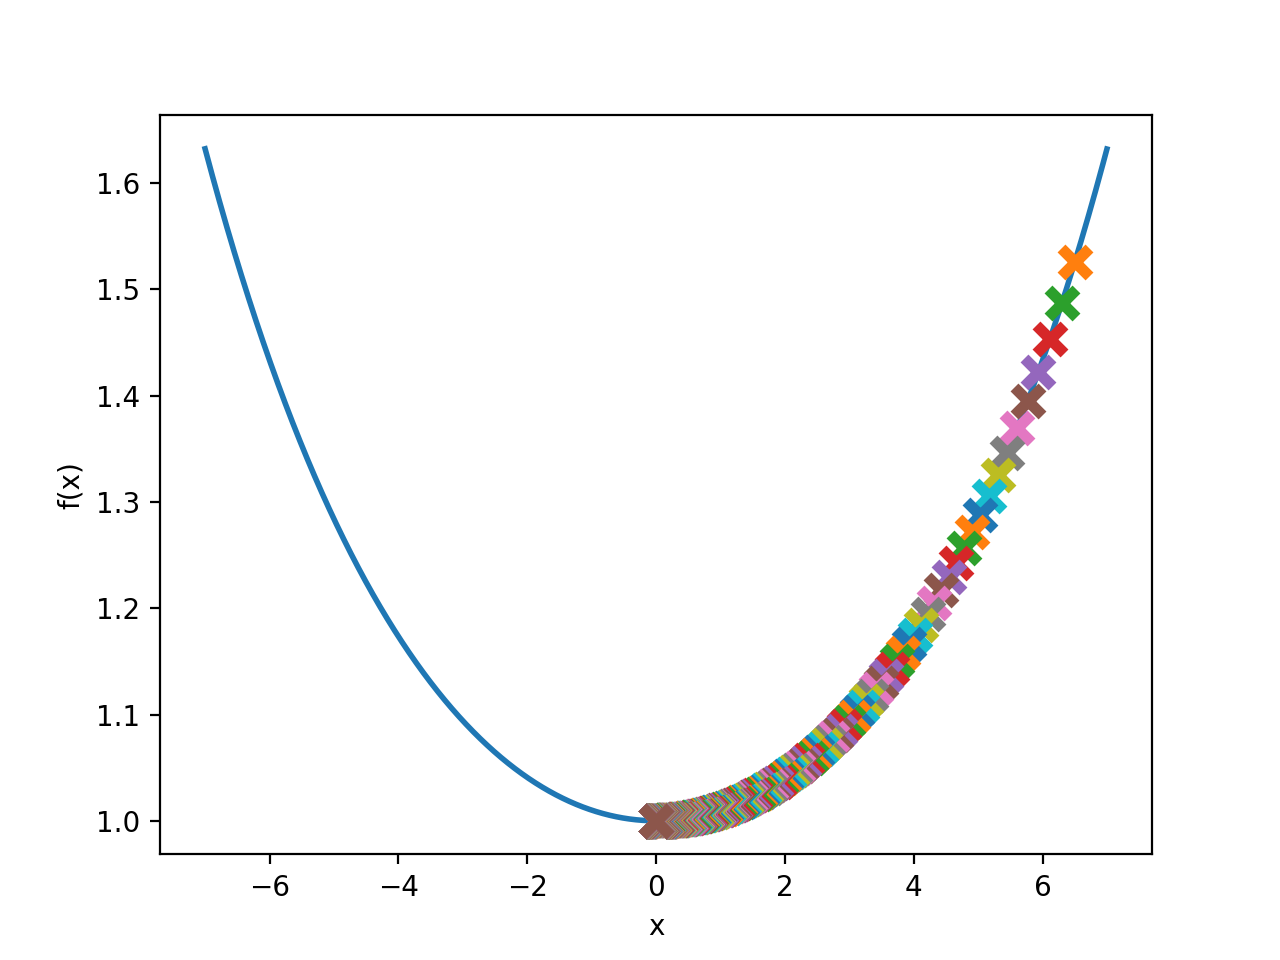

<IPython.core.display.Javascript object>


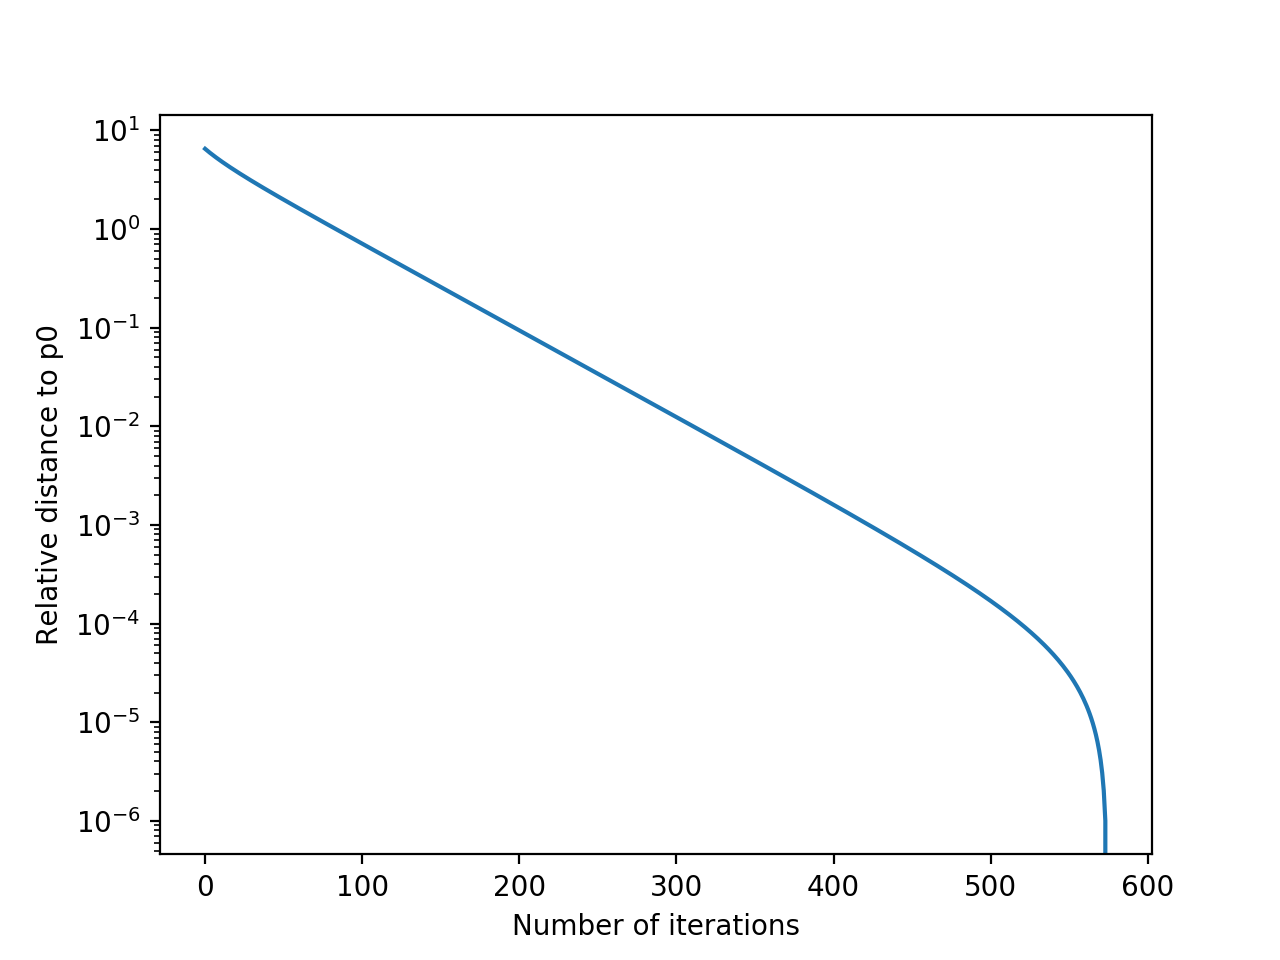

In [24]:
f = lambda x: np.exp(x**2 / 100.)  # lambda function defining f(x)
df = lambda x: (x/50.)*np.exp(x**2 / 100.) # lambda function defining df/dx

# initial point from which we optimize
x0 = np.array([6.5])
# gradient descent
x_steps = gradient_descent(x0, f, df)    

# we  want to plot results from x=-10 to x=10
x = np.arange(-7.,7.,0.001)
# plot results
plot_descent1D(x_steps, x, f)
fig = compare_convergence(x_steps, x_steps[-1,:])

### 1.2 An example where we minimize a 2D function using gradient descent

The function minimized here is $$f(x) = \frac{1}{2} x^T \begin{bmatrix}10&1\\1&2 \end{bmatrix}x$$ and its gradient is $$\frac{df}{dx} = \begin{bmatrix}10&1\\1&2 \end{bmatrix}x$$
We use here lambda functions to define these functions and pass them as callable functions to our algorithms

<IPython.core.display.Javascript object>


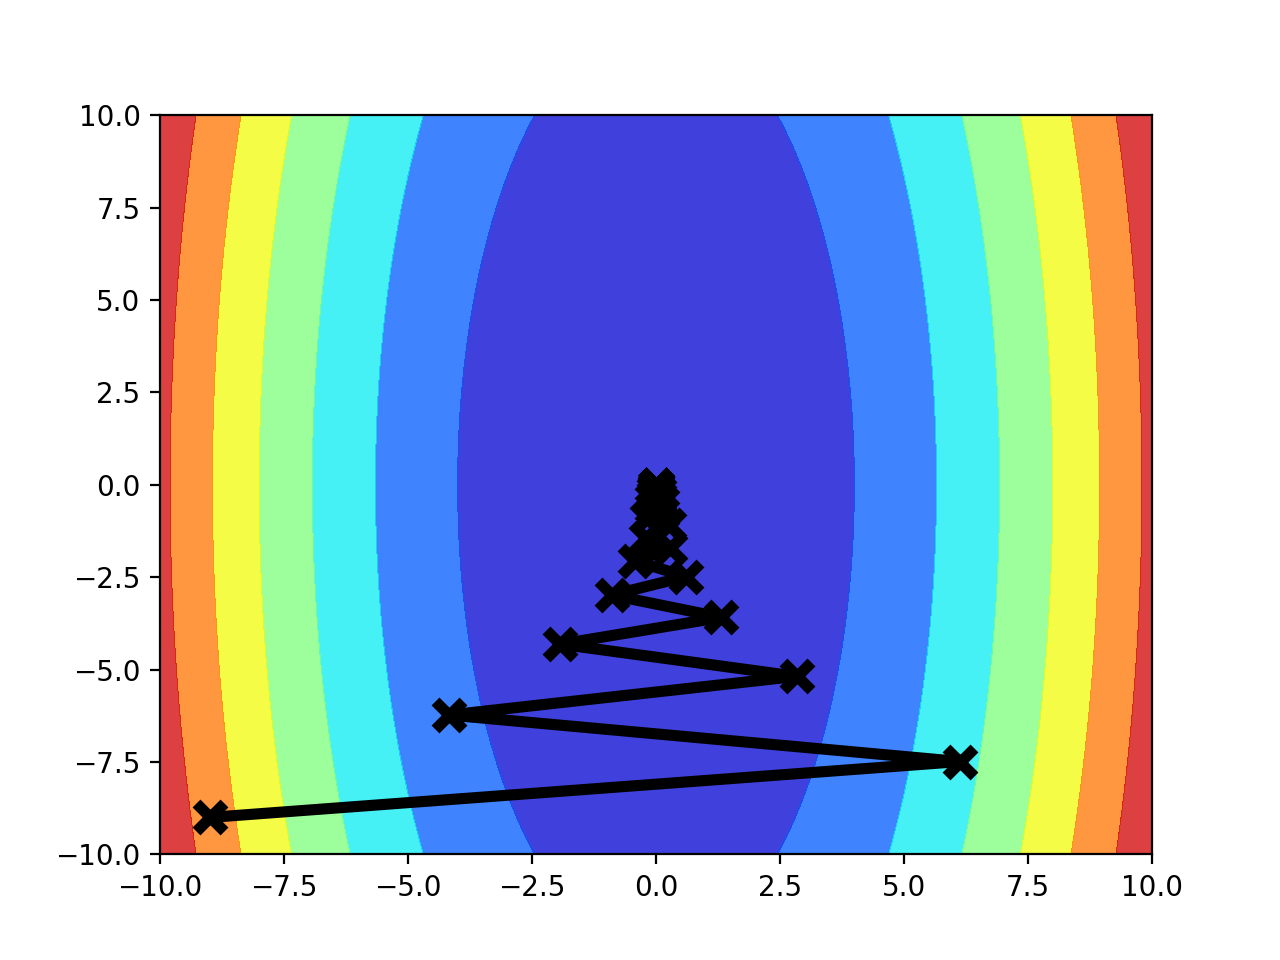

<IPython.core.display.Javascript object>


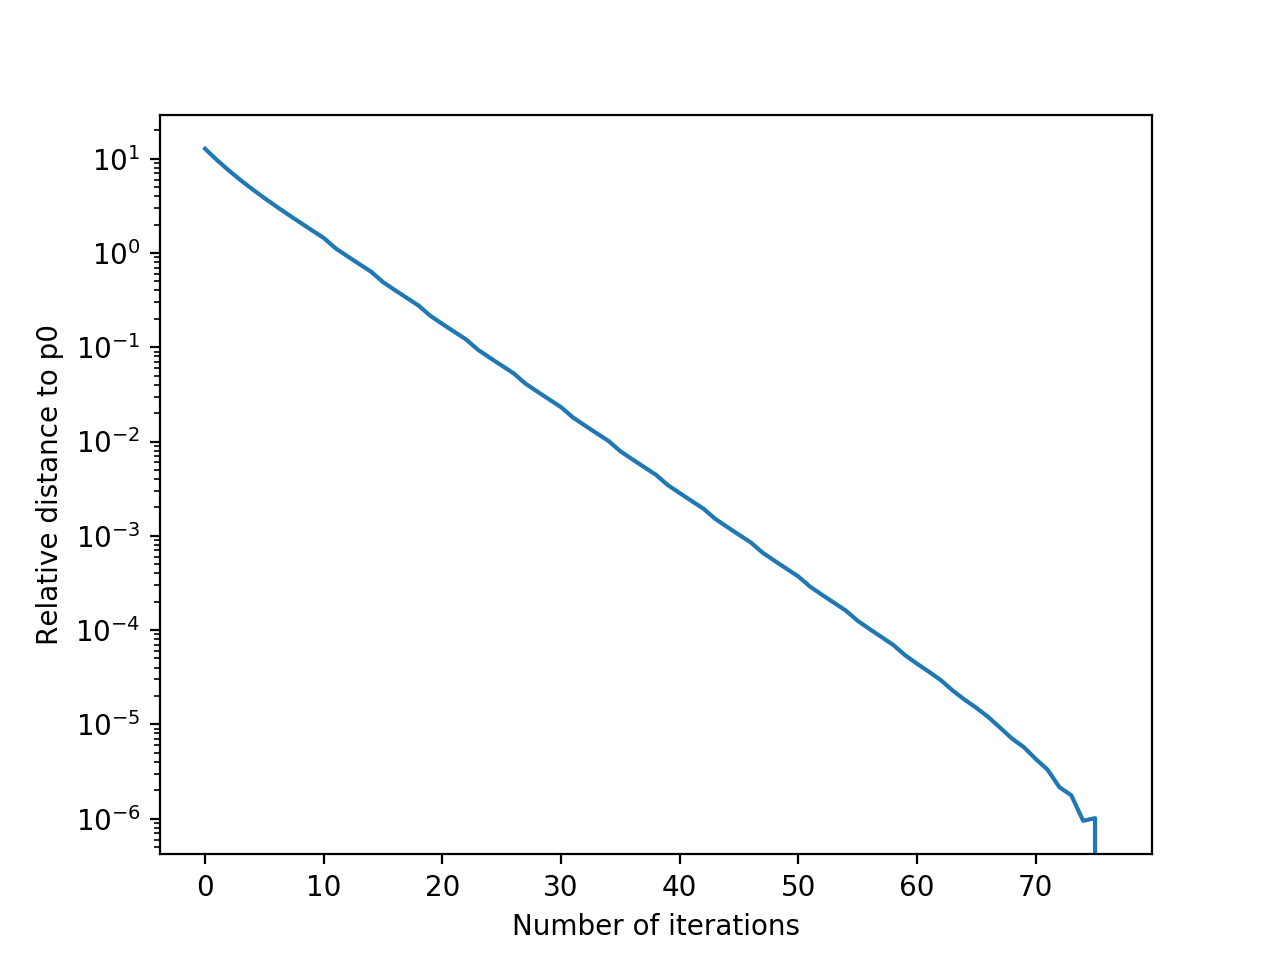

In [25]:
f = lambda x: 0.5*x.dot(np.array([[10,0],[0,1]])).dot(x) # lambda function defining f(x)
df = lambda x: np.array([[10,0],[0,1]]).dot(x) # lambda function defining df/dx

# initial 2D point from which we optimize
x0 = np.array([-9., -9.])        
       
# gradient descent    
x_steps = gradient_descent(x0, f, df) 
# we plot the results in a [-10,10]x[-10,10] box
plot_descent2D(x_steps, [-10., 10.], [-10., 10.], f)
fig = compare_convergence(x_steps, x_steps[-1,:])

## Part 2: Exercise 2 of Homework 1

### 2.1 Minimize a 1D function using Newton Method

The function minimized here is 
$$f(x) = \mathrm{e}^{\frac{x^2}{100}}$$
Its first order gradient is
$$\frac{df}{dx} = \frac{x}{50}\mathrm{e}^{\frac{x^2}{100}}$$
Its second order gradient is
$$\frac{d^2f}{dx^2} = (\frac{1}{50} + \frac{x^2}{250})\mathrm{e}^{\frac{x^2}{100}}$$

<IPython.core.display.Javascript object>


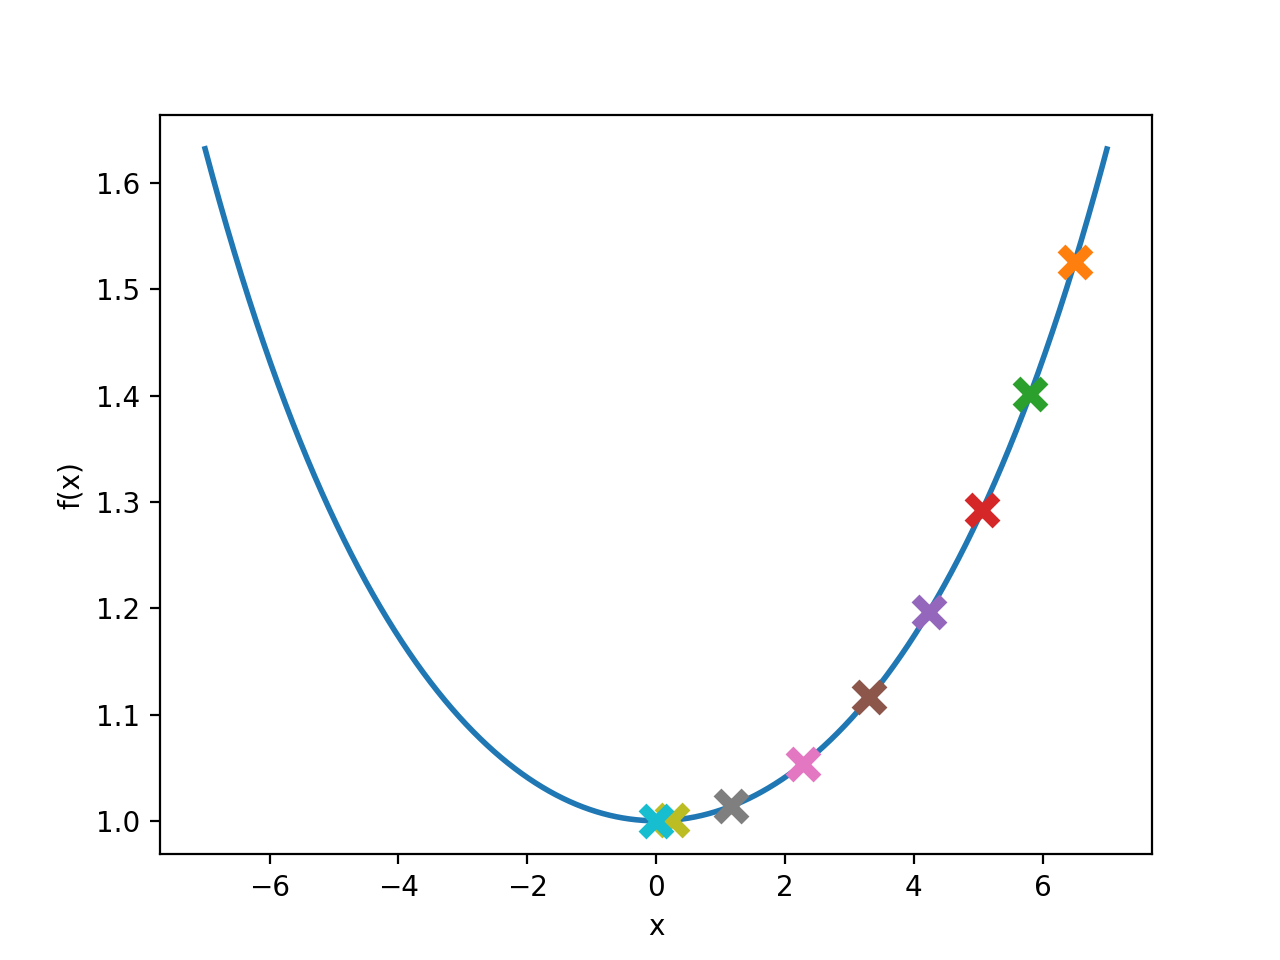

<IPython.core.display.Javascript object>


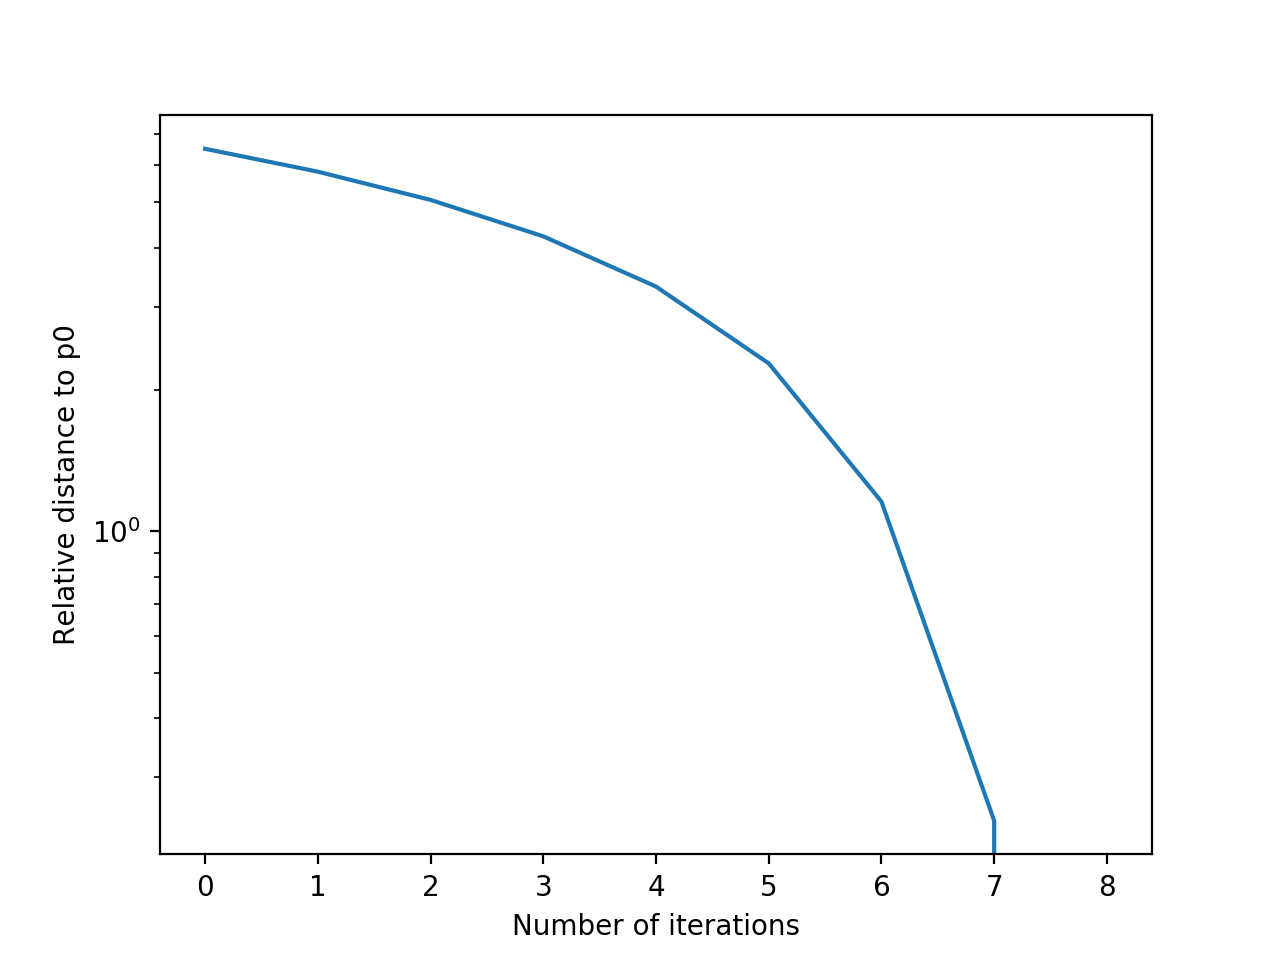

In [26]:
f = lambda x: np.exp(x**2 / 100.)  # lambda function defining f(x)
df = lambda x: (x/50.)*np.exp(x**2 / 100.) # lambda function defining df/dx
ddf = lambda x: (1/50. + x**2/250) * np.exp(x**2 / 100.) # lambda function defining d^2f/dx^2

# initial point from which we optimize
x0 = np.array([6.5])
# gradient descent
x_steps = newton_method(x0, f, df, ddf)

# we  want to plot results from x=-10 to x=10
x = np.arange(-7.,7.,0.001)
# plot results
plot_descent1D(x_steps, x, f)
fig = compare_convergence(x_steps, x_steps[-1,:])

### 2.2 Minimize a 2D function using Netwon Method

The function minimized here is:
$$f(x) = \frac{1}{2} x^T \begin{bmatrix}10&1\\1&2 \end{bmatrix}x$$ 
Its first order gradient is:
$$\frac{df}{dx} = \begin{bmatrix}10&1\\1&2 \end{bmatrix}x$$
Its first order gradient is:
$$\frac{d^2f}{dx^2} = \begin{bmatrix}10&1\\1&2 \end{bmatrix}$$

<IPython.core.display.Javascript object>


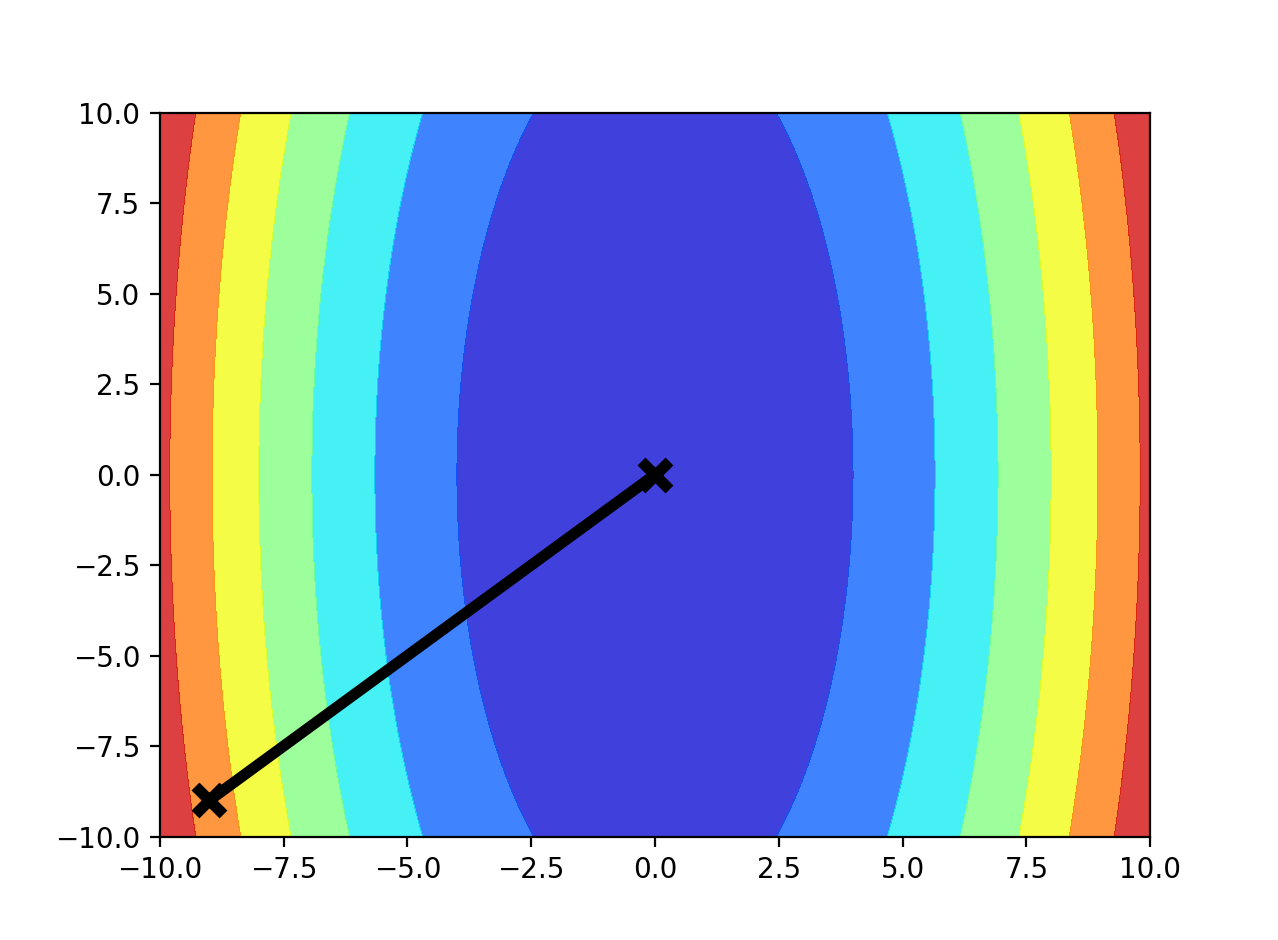

<IPython.core.display.Javascript object>


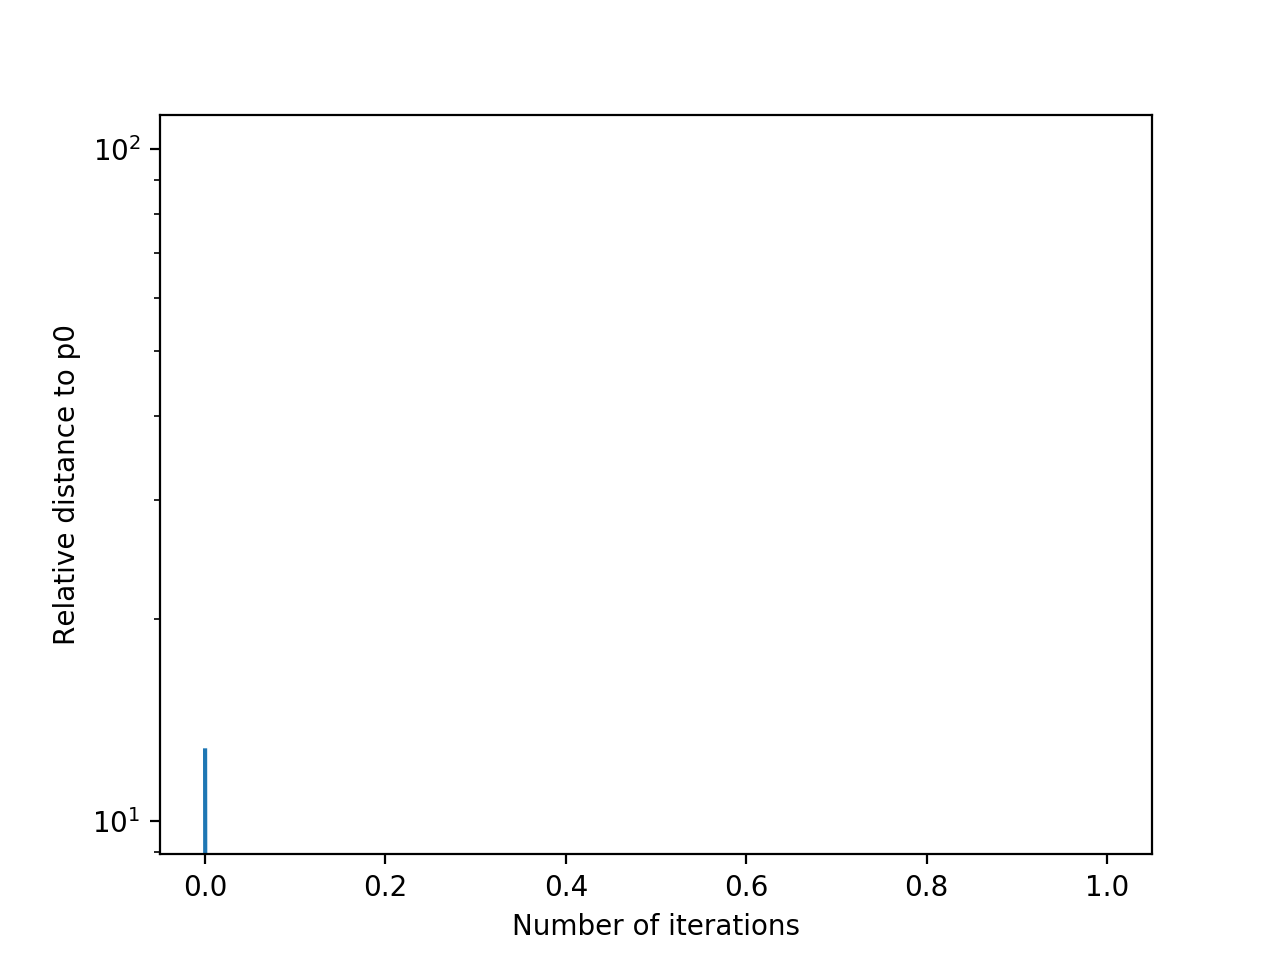

In [18]:
f = lambda x: 0.5*x.dot(np.array([[10,0],[0,1]])).dot(x) # lambda function defining f(x)
df = lambda x: np.array([[10,0],[0,1]]).dot(x) # lambda function defining df/dx
ddf = lambda x: np.array([[10,0],[0,1]])

# initial 2D point from which we optimize
x0 = np.array([-9., -9.])        
       
x_steps = newton_method(x0, f, df, ddf)

# we plot the results in a [-10,10]x[-10,10] box
plot_descent2D(x_steps, [-10., 10.], [-10., 10.], f)
fig = compare_convergence(x_steps, x_steps[-1,:])